# Learning TSP Requires Rethinking Generalization

## Abstract

End-to-end training of neural network solvers for combinatorial problems such as the Travelling Salesman Problem is intractable and inefficient beyond a few hundreds of nodes. 
While state-of-the-art Machine Learning approaches perform closely to classical solvers for trivially small sizes, they are unable to generalize the learnt policy to larger instances of practical scales.
Towards leveraging transfer learning to solve large-scale TSPs, this paper identifies inductive biases, model architectures and learning algorithms that promote generalization to instances larger than those seen in training. 
Our controlled experiments provide the first principled investigation into such zero-shot generalization, revealing that extrapolating beyond training data requires rethinking the entire neural combinatorial optimization pipeline, from network layers and learning paradigms to evaluation protocols.

## End-to-end Pipeline

Towards building scale-invariant learning-based solvers,
this paper aims to identify inductive biases, model architectures and learning paradigms that promote zero-shot generalization to instances larger than those seen in training.
To perform a controlled study, we unify recent and state-of-the-art ideas from neural combinatorial optimization literature through describing a generic five stage pipeline for end-to-end learning of combinatorial problems on graphs:
1. **Problem Definition:** The problem is defined on a graph, which may undergo sparsification/reduction through heuristics.
2. **Graph Encoding:** Embeddings for each graph node are obtained using a Graph Neural Network (GNN).
3. **Solution Decoding:** Probabilities are assigned to each node for belonging to the solution set. Probabilites can be assigned independent of one-another (i.e. Non-autoregressive decoding) or conditionally through a node-by-node traversal (i.e. Autoregressive decoding).
4. **Solution Search:** The predicted probabilities are converted into discrete decisions through classical graph search techniques such as greedy search or beam search.
5. **Policy Learning:** The entire model in trained end-to-end via imitating an optimal solver (i.e. supervised learning) or through minimizing a reward signal (i.e. reinforcement learning).

## Experimental Setup

In general, our experiment design focuses on practicality: we aim to isolate the impact of various components of the aforementioned pipeline when training on trivial/small problem instances (TSP20-50) and generalizing to instances with up to 200 nodes.
We do not want to overparameterize our models nor overfit to training instance size.
Hence, we do not train very large models or use extensive computation.

In a nutshell, we feel that if a model architecture or learning paradigm is a good inductive bias for solving TSP, it should be able to:
(1) learn TSP20-50 without extensive compute/parameters; and 
(2) generalize reasonably to TSP10-200. 

### Datasets
Models are trained on TSP20, TSP50, TSP100, and variable TSP20-50; 1,280,000 supervised training samples, trained for 10 epochs with a batch size of 128 and a learning rate 1e-4;
for reinforcement learning, 128,000 randomly generated instances (without optimal solutions), trained for 100 epochs with the same setup.

Thus, models trained with both learning paradigms see a total of 12,800,000 TSP samples.
Considering that TSP20-50 are trivial in terms of complexity as they can be solved by simpler non-learnt heuristics, learning good solvers at this scale should not require days of training or millions of instances.

### Model setup

For Autoregressive (AR) decoder models, we use 3 graph encoder layers (GNN layers) followed by 1 autoregressive decoder layer (which uses an attention mechanism to select the next node at each step), and hidden dimension of 128.
For Non-Autoregressive (NAR) decoder models, we use 4 graph encoder layers followed by the predictor head (a simple MLP), and hidden dimension of 128. 

These settings result in approx. 350,000 trainable parameters for each model, irrespective of decoder type.

### Evaluation

We measure predicted tour length and optimality gap w.r.t. the optimal solutions (from Concorde) on 1,280 samples of TSP10, TSP20, TSP30, ..., TSP190, TSP200 (in total 1,280 times 20 = 25,600 samples).
Thus, for each model setup permutation, we can plot a line graph of the optimality gap (y-axis) vs. the problem size (x-axis), along with a 99 %-ile confidence interval. 
Plotting line graphs for multiple models on the same figure can help us identify which setup results in: 
(1) better performance on the training size range TSP20-50; as well as 
(2) better generalization to instances upto TSP200, significatly larger and more complex than those seen in training. 

In [2]:
import os
import numpy as np
import pandas as pd
import pickle
import json

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs('results/img/', exist_ok=True)
np.random.seed(1234)

In [3]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

In [4]:
# Dict to format names for display
format_name = {
    # Search settings
    'greedy': "Greedy Search",
    'bs128': "Beam Search (width=128)",
    'bs512': "Beam Search (width=512)",
    'bs1280': "Beam Search (width=1280)",
    'sample128': "Sampling (128 soln.)",
    'sample512': "Sampling (512 soln.)",
    'sample1280': "Sampling (1280 soln.)",
}

def opts_to_df(opts_list, addn_col_name="Additional", add_concorde=False, add_heuristic=False):
    plot = {
        "TSP Size": [],
        "Model": [],
        "Search Setting": [],
        "GT Tour Length": [],
        "Predicted Tour Length": [],
        "Optimality Gap (%)": [],
        "Evaluation Time": [],
        "Additional": []  # for any additional information
    }

    for opts in opts_list:
        for model, name, addn in zip(opts.models, opts.names, opts.addn):
            dataset_basename, ext = os.path.splitext(os.path.split(opts.dataset)[-1])
            model_name = "_".join(os.path.normpath(os.path.splitext(model)[0]).split(os.sep)[-2:])
            results_dir = os.path.join('results', dataset_basename)
            out_file = os.path.join(results_dir, "{}-{}-{}{}-t1-{}-{}{}.pkl".format(
                dataset_basename, model_name,
                opts.decode_strategy,
                opts.width if opts.decode_strategy != 'greedy' else '',
                opts.offset, opts.offset + opts.val_size, ext
            ))

            results = pickle.load(open(out_file, 'rb'))
            costs, gt_costs, tours, gt_tours, opt_gap, durations = zip(*results)
            num_nodes = ([len(tour) for tour in tours])

            plot["TSP Size"] += num_nodes
            plot["Model"] += ([name]*len(tours))
            plot["Search Setting"] += ([format_name[opts.decode_strategy+str(opts.width) if opts.decode_strategy!='greedy' else 'greedy']]*len(tours))
            plot["GT Tour Length"] += gt_costs
            plot["Predicted Tour Length"] += costs
            plot["Optimality Gap (%)"] += opt_gap
            plot["Evaluation Time"] += durations
            plot["Additional"] += ([addn]*len(tours))
            
    if add_concorde:
        plot["TSP Size"] += num_nodes
        plot["Model"] += (["Concorde"]*len(tours))
        plot["Search Setting"] += (["None"]*len(tours))
        plot["GT Tour Length"] += gt_costs
        plot["Predicted Tour Length"] += gt_costs
        plot["Optimality Gap (%)"] += ([0.0]*len(tours))
        plot["Evaluation Time"] += ([0.0]*len(tours))
        plot["Additional"] += (["Concorde"]*len(tours))
        
    if add_heuristic:
        dataset_basename, ext = os.path.splitext(os.path.split(opts.dataset)[-1])
        results_dir = os.path.join('results', dataset_basename)
        out_file = os.path.join(results_dir, "{}n{}-farthest_insertion{}.pkl".format(
                dataset_basename, opts.val_size, ext
            ))
        results = pickle.load(open(out_file, 'rb'))
        costs, gt_costs, tours, gt_tours, opt_gap, durations = zip(*results)
        num_nodes = ([len(tour) for tour in tours])

        plot["TSP Size"] += num_nodes
        plot["Model"] += (["Insertion Heuristic"]*len(tours))
        plot["Search Setting"] += (["Greedy Search"]*len(tours))
        plot["GT Tour Length"] += gt_costs
        plot["Predicted Tour Length"] += costs
        plot["Optimality Gap (%)"] += opt_gap
        plot["Evaluation Time"] += durations
        plot["Additional"] += (["Insertion Heuristic"]*len(tours))
        
    # Convert to dataframe
    df_plot = pd.DataFrame.from_dict(plot)
    # Rename additional column
    df_plot.columns = list(df_plot.columns[:-1]) + [addn_col_name]
    return df_plot

---

# Learning from fixed vs. variable sized TSP instances

1. **Problem Definition:** Separate models are trained on fully connected graphs of instances from TSP20, TSP50, TSP100, and TSP20-50.
2. **Graph Encoding:** Graph ConvNet with Max aggregation
3. **Solution Decoding:** Autoregressive
4. **Solution Search:** Greedy search, Beam search
5. **Policy Learning:** Supervised learning

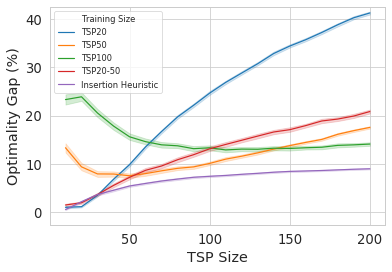

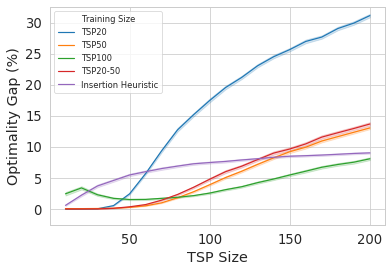

In [7]:
class opts1:
    models = [
        'outputs/tspsl_20-20/sl-ar-20-full-gnn-max_20200305T170708',
        'outputs/tspsl_50-50/sl-ar-50-full-gnn-max_20200305T170752',
        'outputs/tspsl_100-100/sl-ar-100-full-gnn-max_20200305T170924',
#         'outputs/tsp_200-200/rl-ar-200-20pnn-gnn-max-ln-lowlr_20200428T092228',
        'outputs/tspsl_20-50/sl-ar-var-full-gnn-max_20200305T171042'
    ]
    names = [
        'TSP20',
        'TSP50',
        'TSP100',
#         'TSP200',
        'TSP20-50',
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'greedy'
    width = 0
    offset = 0
    val_size = 25600
    
class opts2:
    models = [
        'outputs/tspsl_20-20/sl-ar-20-full-gnn-max_20200305T170708',
        'outputs/tspsl_50-50/sl-ar-50-full-gnn-max_20200305T170752',
        'outputs/tspsl_100-100/sl-ar-100-full-gnn-max_20200305T170924',
#         'outputs/tsp_200-200/rl-ar-200-20pnn-gnn-max-ln-lowlr_20200428T092228',
        'outputs/tspsl_20-50/sl-ar-var-full-gnn-max_20200305T171042'
    ]
    names = [
        'TSP20',
        'TSP50',
        'TSP100',
#         'TSP200',
        'TSP20-50',
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 128
    offset = 0
    val_size = 25600

    
ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue="Training Size", # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts1], addn_col_name='Training Size', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2.5, 42.5))
# ax.set_title("Fixed vs. variable sized TSP instances (Greedy search)")
ax.get_figure().savefig("results/img/fixed_vs_var-sl-ar-full-gnn_max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue="Training Size", # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts2], addn_col_name='Training Size', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2.5, 32.5))
# ax.set_title("Fixed vs. variable sized TSP instances (Beam search, width=128)")
ax.get_figure().savefig("results/img/fixed_vs_var-sl-ar-full-gnn_max-bs128.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

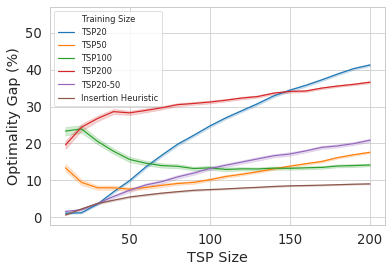

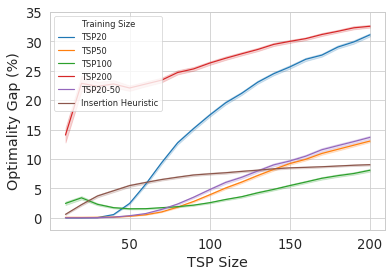

In [82]:
class opts1:
    models = [
        'outputs/tspsl_20-20/sl-ar-20-full-gnn-max_20200305T170708',
        'outputs/tspsl_50-50/sl-ar-50-full-gnn-max_20200305T170752',
        'outputs/tspsl_100-100/sl-ar-100-full-gnn-max_20200305T170924',
        'outputs/tsp_200-200/rl-ar-200-20pnn-gnn-max-ln-lowlr_20200428T092228',
        'outputs/tspsl_20-50/sl-ar-var-full-gnn-max_20200305T171042'
    ]
    names = [
        'TSP20',
        'TSP50',
        'TSP100',
        'TSP200',
        'TSP20-50',
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'greedy'
    width = 0
    offset = 0
    val_size = 25600
    
class opts2:
    models = [
        'outputs/tspsl_20-20/sl-ar-20-full-gnn-max_20200305T170708',
        'outputs/tspsl_50-50/sl-ar-50-full-gnn-max_20200305T170752',
        'outputs/tspsl_100-100/sl-ar-100-full-gnn-max_20200305T170924',
        'outputs/tsp_200-200/rl-ar-200-20pnn-gnn-max-ln-lowlr_20200428T092228',
        'outputs/tspsl_20-50/sl-ar-var-full-gnn-max_20200305T171042'
    ]
    names = [
        'TSP20',
        'TSP50',
        'TSP100',
        'TSP200',
        'TSP20-50',
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 128
    offset = 0
    val_size = 25600

    
ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue="Training Size", # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts1], addn_col_name='Training Size', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2, 57))
# ax.set_title("Fixed vs. variable sized TSP instances (Greedy search)")
ax.get_figure().savefig("results/img/fixed_vs_var-sl-ar-full-gnn_max-greedy-with-tsp200.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue="Training Size", # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts2], addn_col_name='Training Size', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2, 35))
# ax.set_title("Fixed vs. variable sized TSP instances (Beam search, width=128)")
ax.get_figure().savefig("results/img/fixed_vs_var-sl-ar-full-gnn_max-bs128-with-tsp200.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

## Findings
- Using variable graph sizes helps the model retain performance across the minimum and maximum problem sizes seen in training, but the model is unable to generalize to larger problems any better than a similar model trained solely on the maximum problem size. This suggests that variable graph training does not help in interpolation beyond training size.
- With the NAR decoder (not shown above), training on variable sizes provides more robustness when generalizing as compared to training on the fixed maximum size (TSP50). At the same time, all NAR models perform and generalize very poorly compared to AR models, casting a shadow over any conclusions drawn from NAR models.

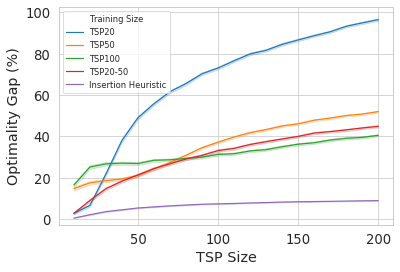

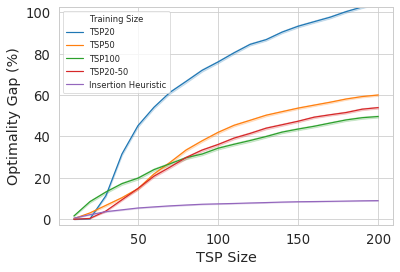

In [8]:
class opts1:
    models = [
        'outputs/tspsl_20-20/sl-nar-20-full-gnn-max_20200305T163524',
        'outputs/tspsl_50-50/sl-nar-50-full-gnn-max_20200305T163443',
        'outputs/tspsl_100-100/sl-nar-100-full-gnn-max_20200308T170132',
        'outputs/tspsl_20-50/sl-nar-var-full-gnn-max_20200305T164105'
    ]
    names = [
        'TSP20',
        'TSP50',
        'TSP100',
        'TSP20-50',
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'greedy'
    width = 0
    offset = 0
    val_size = 25600
    
class opts2:
    models = [
        'outputs/tspsl_20-20/sl-nar-20-full-gnn-max_20200305T163524',
        'outputs/tspsl_50-50/sl-nar-50-full-gnn-max_20200305T163443',
        'outputs/tspsl_100-100/sl-nar-100-full-gnn-max_20200308T170132',
        'outputs/tspsl_20-50/sl-nar-var-full-gnn-max_20200305T164105'
    ]
    names = [
        'TSP20',
        'TSP50',
        'TSP100',
        'TSP20-50',
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 128
    offset = 0
    val_size = 25600

    
ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue="Training Size", # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts1], addn_col_name='Training Size', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2.5, 102.5))
# ax.set_title("Fixed vs. variable sized TSP instances (Greedy search)")
ax.get_figure().savefig("results/img/fixed_vs_var-sl-nar-full-gnn_max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue="Training Size", # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts2], addn_col_name='Training Size', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2.5, 102.5))
# ax.set_title("Fixed vs. variable sized TSP instances (Beam search, width=128)")
ax.get_figure().savefig("results/img/fixed_vs_var-sl-nar-full-gnn_max-bs128.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

---

# Learning from full vs. sparse graphs

1. **Problem Definition:** Separate models are trained on TSP20-50 graphs with the following graph structure definitions:
    - Fully connected: all nodes are connected to all other nodes
    - `k`-Nearest Neighbors: nodes are connected to their `k` nearest neoghbors, irrespective of the size of the problem instance. Such an approach has been used in DL for TSP literature, especially in order to scale to large instances where operating on full graphs in not tractable. Additionally, this approach fixes the degree of graph nodes, which should intuitively support better transfer to larger graphs.
    - `k%`-Nearest Neighbors: nodes are connected to `k'` nearest neighbors, where `k' = k * graph_size` and `k` is a float value. This approach does not fix the degrees, but allows the sparse graph structure to be 'adaptable' to the number of nodes, allowing more extensive message passing for larger graphs while still retaining sparsity for efficiency. 
2. **Graph Encoding:** Graph ConvNet with Max aggregation
3. **Solution Decoding:** Autoregressive
4. **Solution Search:** Greedy search, Beam search
5. **Policy Learning:** Supervised learning

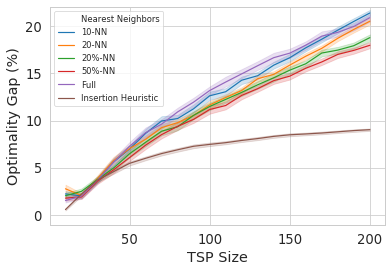

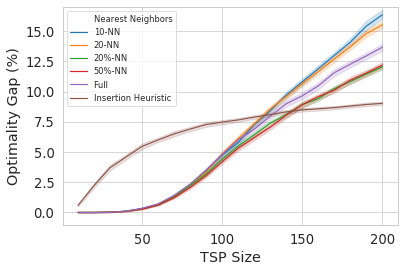

In [9]:
class opts1:
    models = [
#         'outputs/tspsl_20-50/sl-ar-var-5nn-gnn-max_20200305T174112',
        'outputs/tspsl_20-50/sl-ar-var-10nn-gnn-max_20200305T173954',
        'outputs/tspsl_20-50/sl-ar-var-20nn-gnn-max_20200305T173858',
        'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931',
        'outputs/tspsl_20-50/sl-ar-var-50pnn-gnn-max_20200308T172907',
        'outputs/tspsl_20-50/sl-ar-var-full-gnn-max_20200305T171042',
    ]
    names = [
#         '5-NN',
        '10-NN',
        '20-NN',
        '20%-NN',
        '50%-NN',
        'Full',
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'greedy'
    width = 0
    offset = 0
    val_size = 25600
    
class opts2:
    models = [
#         'outputs/tspsl_20-50/sl-ar-var-5nn-gnn-max_20200305T174112',
        'outputs/tspsl_20-50/sl-ar-var-10nn-gnn-max_20200305T173954',
        'outputs/tspsl_20-50/sl-ar-var-20nn-gnn-max_20200305T173858',
        'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931',
        'outputs/tspsl_20-50/sl-ar-var-50pnn-gnn-max_20200308T172907',
        'outputs/tspsl_20-50/sl-ar-var-full-gnn-max_20200305T171042',
    ]
    names = [
#         '5-NN',
        '10-NN',
        '20-NN',
        '20%-NN',
        '50%-NN',
        'Full',
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 128
    offset = 0
    val_size = 25600

    
ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue='Nearest Neighbors', # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts1], addn_col_name='Nearest Neighbors', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-1, 22))
# ax.set_title("Fully connected vs. k-NN sparse graph (Greedy search)")
ax.get_figure().savefig("results/img/full_vs_knn-sl-ar-var-gnn_max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue='Nearest Neighbors', # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts2], addn_col_name='Nearest Neighbors', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-1, 17))
# ax.set_title("Fully connected vs. k-NN sparse graph (Beam search, width=128)")
ax.get_figure().savefig("results/img/full_vs_knn-sl-ar-var-gnn_max-bs128.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

## Findings
- Sparsifying graphs reduces the search space for models, especially for learning useful node embeddings using GNNs, leading to faster training convergence, and, by extension, better performance on training instance sizes as well as generalization to larger sizes.
- However, not all graph sparsification techniques are beneficial for generalization to very large instances. Using `k%`-NN sticks out as the most effective, and **all further experiments use sparse `20%`-NN graphs.**

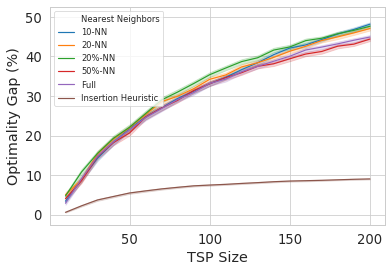

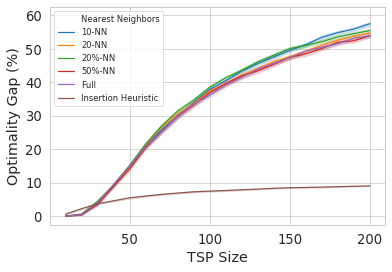

In [10]:
class opts1:
    models = [
#         'outputs/tspsl_20-50/sl-nar-var-5nn-gnn-max_20200306T171631',
        'outputs/tspsl_20-50/sl-nar-var-10nn-gnn-max_20200305T174230',
        'outputs/tspsl_20-50/sl-nar-var-20nn-gnn-max_20200306T171552',
        'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-max_20200308T173056',
        'outputs/tspsl_20-50/sl-nar-var-50pnn-gnn-max_20200308T173014',
        'outputs/tspsl_20-50/sl-nar-var-full-gnn-max_20200305T164105',
    ]
    names = [
#         '5-NN',
        '10-NN',
        '20-NN',
        '20%-NN',
        '50%-NN',
        'Full',
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'greedy'
    width = 0
    offset = 0
    val_size = 25600
    
class opts2:
    models = [
#         'outputs/tspsl_20-50/sl-nar-var-5nn-gnn-max_20200306T171631',
        'outputs/tspsl_20-50/sl-nar-var-10nn-gnn-max_20200305T174230',
        'outputs/tspsl_20-50/sl-nar-var-20nn-gnn-max_20200306T171552',
        'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-max_20200308T173056',
        'outputs/tspsl_20-50/sl-nar-var-50pnn-gnn-max_20200308T173014',
        'outputs/tspsl_20-50/sl-nar-var-full-gnn-max_20200305T164105',
    ]
    names = [
#         '5-NN',
        '10-NN',
        '20-NN',
        '20%-NN',
        '50%-NN',
        'Full',
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 128
    offset = 0
    val_size = 25600

    
ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue='Nearest Neighbors', # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts1], addn_col_name='Nearest Neighbors', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2.5, 52.5))
# ax.set_title("Fully connected vs. k-NN sparse graph (Greedy search)")
ax.get_figure().savefig("results/img/full_vs_knn-sl-nar-var-gnn_max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue='Nearest Neighbors', # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts2], addn_col_name='Nearest Neighbors', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2.5, 62.5))
# ax.set_title("Fully connected vs. k-NN sparse graph (Beam search, width=128)")
ax.get_figure().savefig("results/img/full_vs_knn-sl-nar-var-gnn_max-bs128.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

---

# Curriculum Learning (TODO)

1. **Problem Definition:** Separate models are trained on TSP20-50 graphs with the following learing curriculums:
    - Random: no curriculum, standard RL
    - Increasing difficulty per batch: TSP size per mini-batch is linearly increased from 20 to 50 each epoch. At the end of an epoch, training starts again at TSP20. 
    - Increasing difficulty per epoch: TSP size per epoch is sampled from a normal distribution, whose mean is shifted at the end of each epoch, from 20 to 50 (while the std=5 is kept fixed). Thus, the model sees slightly harder examples at each epoch. 
2. **Graph Encoding:** Graph ConvNet with Max aggregation
3. **Solution Decoding:** Autoregressive
4. **Solution Search:** Greedy search, Beam search
5. **Policy Learning:** Reinforcement learning

In [11]:
# class opts1:
#     models = [
#         'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max_20200313T002243',
#         'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-curriculum-linear_20200327T110137',
#         'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-curriculum-normal_20200327T105537',
#         'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-metarollout_20200328T153244'
#     ]
#     names = [
#         'Random', 'Batch Curriculum', 'Epoch Curriculum', 'Meta Learning'
#     ]
#     addn = names
#     dataset = 'data/tsp/tsp10-200_concorde.txt'
#     decode_strategy = 'greedy'
#     width = 0
#     offset = 0
#     val_size = 25600
    
# class opts2:
#     models = [
#         'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max_20200313T002243',
#         'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-curriculum-linear_20200327T110137',
#         'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-curriculum-normal_20200327T105537',
#         'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-metarollout_20200328T153244'
#     ]
#     names = [
#         'Random', 'Batch Curriculum', 'Epoch Curriculum', 'Meta Learning'
#     ]
#     addn = names
#     dataset = 'data/tsp/tsp10-200_concorde.txt'
#     decode_strategy = 'bs'
#     width = 128
#     offset = 0
#     val_size = 25600
    

# ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
#                   hue='Curriculum Type', # style="Model", # palette=["r", "g", "b"],
#                   ci=99, err_style='band',
#                   data=opts_to_df([opts1], addn_col_name='Curriculum Type', add_heuristic=True)
# )
# ax.legend(loc=2)
# # ax.set_title("Curriculum Learning (Greedy search)")
# ax.get_figure().savefig("results/img/curriculum-rl-ar-var-knn-gnn_max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
# plt.show()

# ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
#                   hue='Curriculum Type', # style="Model", # palette=["r", "g", "b"],
#                   ci=99, err_style='band',
#                   data=opts_to_df([opts2], addn_col_name='Curriculum Type', add_heuristic=True)
# )
# ax.legend(loc=2)
# # ax.set_title("Curriculum Learning (Beam search, width=128)")
# ax.get_figure().savefig("results/img/curriculum-rl-ar-var-knn-gnn_max-bs128.pdf", format='pdf', dpi=1200, bbox_inches='tight')
# plt.show()

---

# Impact of GNN neighborhood aggregation functions

1. **Problem Definition:** TSP20-50 graphs, sparse `20%`-NN graphs
2. **Graph Encoding:** Separate Graph ConvNet models are trained for common aggregation functions: Max, Mean and Sum:
```
        h_i = ReLU ( U*h_i + Aggr.( sigma_ij, V*h_j) ),
            where Aggr. is an aggregation function: sum/mean/max.
        sigma_ij = sigmoid( A*h_i + B*h_j + C*e_ij ),
        e_ij = ReLU ( A*h_i + B*h_j + C*e_ij ),
```
All Graph ConvNets use the edge gating mechanisms, residual connections and batch normalization (with batch statistics).
Additionally, we also experiment with graph structure-agnostic models where no neighborhood features are aggreagated, i.e., independent MLPs on node features.
3. **Solution Decoding:** Autoregressive
4. **Solution Search:** Greedy search, Beam search
5. **Policy Learning:** Supervised learning

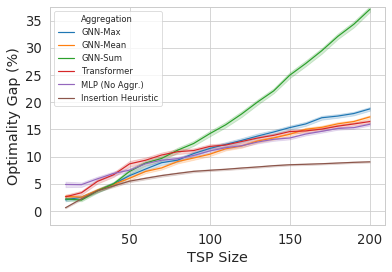

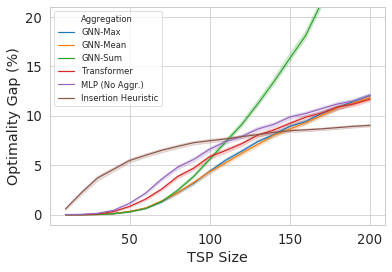

In [14]:
class opts1:
    models = [
        'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931',
        'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-mean_20200310T094833',
        'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-sum_20200310T094801',
        'outputs/tspsl_20-50/sl-ar-var-full-gat_20200521T141137',
        'outputs/tspsl_20-50/sl-ar-var-full-mlp_20200306T182155'
    ]
    names = [
        'GNN-Max',
        'GNN-Mean',
        'GNN-Sum',
        'Transformer',
        'MLP (No Aggr.)'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'greedy'
    width = 0
    offset = 0
    val_size = 25600
    
class opts2:
    models = [
        'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931',
        'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-mean_20200310T094833',
        'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-sum_20200310T094801',
        'outputs/tspsl_20-50/sl-ar-var-full-gat_20200521T141137',
        'outputs/tspsl_20-50/sl-ar-var-full-mlp_20200306T182155'
    ]
    names = [
        'GNN-Max',
        'GNN-Mean',
        'GNN-Sum',
        'Transformer',
        'MLP (No Aggr.)'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 128
    offset = 0
    val_size = 25600
    

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue='Aggregation', # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts1], addn_col_name='Aggregation', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2.5, 37.5))
# ax.set_title("GNN aggregation functions (Greedy search)")
ax.get_figure().savefig("results/img/gnn_aggregation-sl-ar-var-knn-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue='Aggregation', # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts2], addn_col_name='Aggregation', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-1, 21))
# ax.set_title("GNN aggregation functions (Beam search, width=128)")
ax.get_figure().savefig("results/img/gnn_aggregation-sl-ar-var-knn-bs128.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

## Findings
- The choice of aggregation function does not matter within the training size range TSP20-50. 
- As we move out of distribution, we find that aggregation functions that are agnostic to neighborhood size/node degree, e.g. Mean and Max, generalize better to larger graphs. **We use Max aggregation in further experiments as it performed consistently better for both AR (shown above) and NAR models.** 
- Using summation as aggregation is disastrous as instance size increases, despite using normalization after each layer.
- Structure-agnostic MLP models perform surprisingly well with AR decoding (shown above in red), but are completely useless with NAR decoding (shown later). More on this when we analyze the choice of decoder.

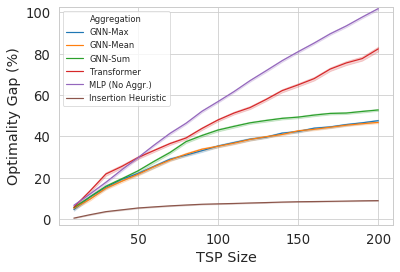

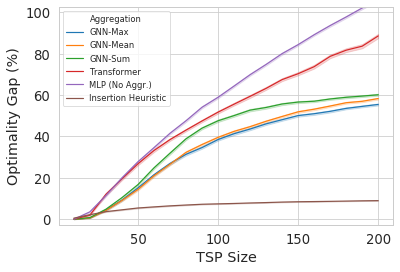

In [15]:
class opts1:
    models = [
        'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-max_20200308T173056',
        'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-sum_20200310T094716',
        'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-mean_20200310T094701',
        'outputs/tspsl_20-50/sl-nar-var-full-gat_20200521T124702',
        'outputs/tspsl_20-50/sl-nar-var-full-mlp_20200306T182142'
    ]
    names = [
        'GNN-Max',
        'GNN-Mean',
        'GNN-Sum',
        'Transformer',
        'MLP (No Aggr.)'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'greedy'
    width = 0
    offset = 0
    val_size = 25600
    
class opts2:
    models = [
        'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-max_20200308T173056',
        'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-sum_20200310T094716',
        'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-mean_20200310T094701',
        'outputs/tspsl_20-50/sl-nar-var-full-gat_20200521T124702',
        'outputs/tspsl_20-50/sl-nar-var-full-mlp_20200306T182142'
    ]
    names = [
        'GNN-Max',
        'GNN-Mean',
        'GNN-Sum',
        'Transformer',
        'MLP (No Aggr.)'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 128
    offset = 0
    val_size = 25600
    

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue='Aggregation', # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts1], addn_col_name='Aggregation', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2.5, 102.5))
# ax.set_title("GNN aggregation functions (Greedy search)")
ax.get_figure().savefig("results/img/gnn_aggregation-sl-nar-var-knn-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue='Aggregation', # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts2], addn_col_name='Aggregation', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2.5, 102.5))
# ax.set_title("GNN aggregation functions (Beam search, width=128)")
ax.get_figure().savefig("results/img/gnn_aggregation-sl-nar-var-knn-bs128.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

---

# Impact of Normalization layers after GNN layers

1. **Problem Definition:** TSP20-50 graphs, sparse `20%`-NN graphs
2. **Graph Encoding:** Graph ConvNet with Max aggragation. In each layer, before the ReLU activation, we train separate models where we normalize the node and edge features using the following techniques:
    - BatchNorm (learnt stats), with mean and standard deviations learnt from the training data, i.e., the standard formulation of BatchNorm
    - BatchNorm (batch stats), which uses mean and standard deviations of the mini-batch during both training and evaluation
    - Z-score, which uses mean and standard deviation of the mini-batch but does not learn any affine transformations
    - LayerNorm, which normalizes at the feature level, not the batch level
    - No normalization
3. **Solution Decoding:** Autoregressive
4. **Solution Search:** Greedy search, Beam search
5. **Policy Learning:** Supervised learning

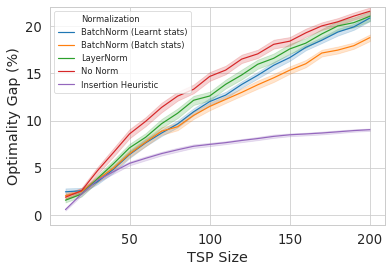

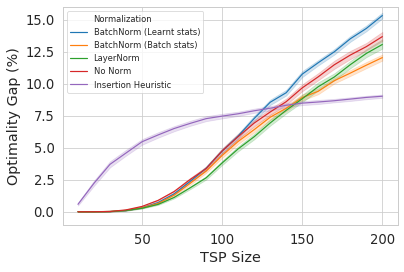

In [16]:
class opts1:
    models = [
        'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-bntrack_20200310T095509',
        'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931',
        'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-ln_20200310T095955',
#         'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-zscore_20200310T095758',
        'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-nonorm_20200310T100115',
    ]
    names = [
        'BatchNorm (Learnt stats)',
        'BatchNorm (Batch stats)',
        'LayerNorm',
#         'Z-Scoring',
        'No Norm',
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'greedy'
    width = 0
    offset = 0
    val_size = 25600
    
class opts2:
    models = [
        'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-bntrack_20200310T095509',
        'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931',
        'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-ln_20200310T095955',
#         'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-zscore_20200310T095758',
        'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-nonorm_20200310T100115',
    ]
    names = [
        'BatchNorm (Learnt stats)',
        'BatchNorm (Batch stats)',
        'LayerNorm',
#         'Z-Scoring',
        'No Norm',
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 128
    offset = 0
    val_size = 25600    

    
ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue='Normalization', # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts1], addn_col_name='Normalization', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-1, 22))
# ax.set_title("Choice of normalization layer (Greedy search)")
ax.get_figure().savefig("results/img/gnn_norm-sl-ar-var-knn-gnn_max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue='Normalization', # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts2], addn_col_name='Normalization', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-1, 16))
# ax.set_title("Choice of normalization layer (Beam search, width=128)")
ax.get_figure().savefig("results/img/gnn_norm-sl-ar-var-knn-gnn_max-bs128.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

## Findings
- BatchNorm is most effective when we use batch statistics during inference as opposed to learnt mean and standard deviation during training. In fact, the standard learnt BatchNorm is worse than not performing normalization or doing a simple z-scoring based on batch statistics. 
- As graph size shifts, mean and standard deviation of hidden features also shifts. Thus LayerNorm (which normalizes at the feature level, independent of batch information) or BatchNorm with batch statistics are smarter choices for generalization to larger sizes. **We use BatchNorm with batch statistics in further experiments.**

---

# Impact of GNN Depth, keeping #params constant

1. **Problem Definition:** TSP20-50 graphs, sparse `20%`-NN graphs
2. **Graph Encoding:** Graph ConvNet with Max aggragation. Keeping the #params fixed at ~330,000, we train separate models with larger number of GNN layers L (and decrease hidden dimension d of each layer).
3. **Solution Decoding:** Autoregressive
4. **Solution Search:** Greedy search, Beam search
5. **Policy Learning:** Supervised learning

In [13]:
# class opts1:
#     models = [
#         'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931',
#         'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-6L96H_20200310T151612',
#         'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-9L80H_20200310T151315'
#     ]
#     names = [
#         'L=3, d=128',
#         'L=6, d=96',
#         'L=9, d=80'
#     ]
#     addn = names
#     dataset = 'data/tsp/tsp10-200_concorde.txt'
#     decode_strategy = 'greedy'
#     width = 0
#     offset = 0
#     val_size = 25600
    
# class opts2:
#     models = [
#         'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931',
#         'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-6L96H_20200310T151612',
#         'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-9L80H_20200310T151315'
#     ]
#     names = [
#         'L=3, d=128',
#         'L=6, d=96',
#         'L=9, d=80'
#     ]
#     addn = names
#     dataset = 'data/tsp/tsp10-200_concorde.txt'
#     decode_strategy = 'bs'
#     width = 128
#     offset = 0
#     val_size = 25600    

    
# ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
#                   hue="Hyperparameters", # style="Model", # palette=["r", "g", "b"],
#                   ci=99, err_style='band',
#                   data=opts_to_df([opts1], addn_col_name="Hyperparameters", add_heuristic=True)
# )
# ax.legend(loc=2)
# ax.get_figure().savefig("results/img/gnn_depth-sl-ar-var-knn-gnn_max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
# plt.show()

# ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
#                   hue="Hyperparameters", # style="Model", # palette=["r", "g", "b"],
#                   ci=99, err_style='band',
#                   data=opts_to_df([opts2], addn_col_name="Hyperparameters", add_heuristic=True)
# )
# ax.legend(loc=2)
# ax.get_figure().savefig("results/img/gnn_depth-sl-ar-var-knn-gnn_max-bs128.pdf", format='pdf', dpi=1200, bbox_inches='tight')
# plt.show()

In [11]:
# class opts1:
#     models = [
#         'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-max_20200308T173056',
#         'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-max-7L96H_20200310T231028',
#         'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-max-10L80H_20200310T151748'
#     ]
#     names = [
#         'L=4, d=128',
#         'L=7, d=96',
#         'L=10, d=80'
#     ]
#     addn = names
#     dataset = 'data/tsp/tsp10-200_concorde.txt'
#     decode_strategy = 'greedy'
#     width = 0
#     offset = 0
#     val_size = 25600
    
# class opts2:
#     models = [
#         'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-max_20200308T173056',
#         'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-max-7L96H_20200310T231028',
#         'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-max-10L80H_20200310T151748'
#     ]
#     names = [
#         'L=4, d=128',
#         'L=7, d=96',
#         'L=10, d=80'
#     ]
#     addn = names
#     dataset = 'data/tsp/tsp10-200_concorde.txt'
#     decode_strategy = 'bs'
#     width = 128
#     offset = 0
#     val_size = 25600    

    
# ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
#                   hue="Hyperparameters", # style="Model", # palette=["r", "g", "b"],
#                   ci=99, err_style='band',
#                   data=opts_to_df([opts1], addn_col_name="Hyperparameters", add_heuristic=True)
# )
# ax.legend(loc=2)
# ax.get_figure().savefig("results/img/gnn_depth-sl-nar-var-knn-gnn_max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
# plt.show()

# ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
#                   hue="Hyperparameters", # style="Model", # palette=["r", "g", "b"],
#                   ci=99, err_style='band',
#                   data=opts_to_df([opts2], addn_col_name="Hyperparameters", add_heuristic=True)
# )
# ax.legend(loc=2)
# ax.get_figure().savefig("results/img/gnn_depth-sl-nar-var-knn-gnn_max-bs128.pdf", format='pdf', dpi=1200, bbox_inches='tight')
# plt.show()

---

# Impact of Aggregation for Graph Embedding

1. **Problem Definition:** TSP20-50 graphs, sparse `20%`-NN graphs
2. **Graph Encoding:** Graph ConvNet with Max aggragation. We train sepearate models for four variants of graph embedding aggregation: mean, max, sum, and none.
3. **Solution Decoding:** Autoregressive
4. **Solution Search:** Greedy search, Beam search
5. **Policy Learning:** Reinforcement learning

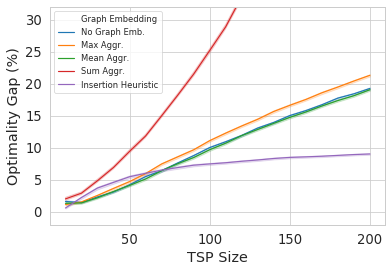

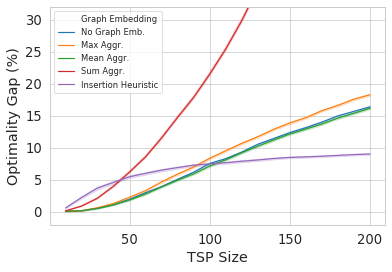

In [17]:
class opts1:
    models = [
        'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-gaggr-none_20200411T145801',
        'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-gaggr-max_20200411T145637',
        'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max_20200313T002243',
        'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-gaggr-sum_20200411T145725',
    ]
    names = [
        'No Graph Emb.',
        'Max Aggr.',
        'Mean Aggr.',
        'Sum Aggr.'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'greedy'
    width = 0
    offset = 0
    val_size = 25600
    
class opts2:
    models = [
        'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-gaggr-none_20200411T145801',
        'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-gaggr-max_20200411T145637',
        'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max_20200313T002243',
        'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-gaggr-sum_20200411T145725',
    ]
    names = [
        'No Graph Emb.',
        'Max Aggr.',
        'Mean Aggr.',
        'Sum Aggr.'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 128
    offset = 0
    val_size = 25600    

    
ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue='Graph Embedding', # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts1], addn_col_name='Graph Embedding', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2, 32))
ax.get_figure().savefig("results/img/gnn_graph_emb-rl-ar-var-knn-gnn_max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue='Graph Embedding', # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts2], addn_col_name='Graph Embedding', add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2, 32))
ax.get_figure().savefig("results/img/gnn_graph_emb-rl-ar-var-knn-gnn_max-bs128.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

---

# Using Recurrent GNN encoders

1. **Problem Definition:** TSP20-50 graphs, sparse `20%`-NN graphs
2. **Graph Encoding:** We explore the use of Recurrent GNN encoders, which can be trained for a certain amount of steps, but can perform more rounds of message passing during inference. The intuition being that larger graphs/more complex TSP instances require more propagation steps to build useful embeddings.
3. **Solution Decoding:** Autoregressive
4. **Solution Search:** Greedy search, Beam search
5. **Policy Learning:** Reinforcement Learning

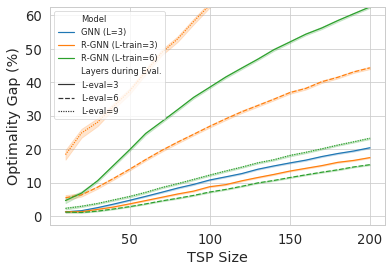

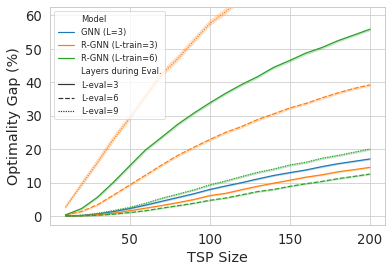

In [18]:
class opts1:
    models = [
        'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-ln_20200313T125908',
        'outputs/tsp_20-50/rl-ar-var-20pnn-rgnn-ln-3L_20200327T110404_eval3L',
        'outputs/tsp_20-50/rl-ar-var-20pnn-rgnn-ln-3L_20200327T110404_eval6L',
        'outputs/tsp_20-50/rl-ar-var-20pnn-rgnn-ln-3L_20200327T110404_eval9L',
        'outputs/tsp_20-50/rl-ar-var-20pnn-rgnn-ln-6L_20200327T110454_eval3L',
        'outputs/tsp_20-50/rl-ar-var-20pnn-rgnn-ln-6L_20200327T110454_eval6L',
        'outputs/tsp_20-50/rl-ar-var-20pnn-rgnn-ln-6L_20200327T110454_eval9L',
    ]
    names = [
        'GNN (L=3)', 
        'R-GNN (L-train=3)', 
        'R-GNN (L-train=3)', 
        'R-GNN (L-train=3)',
        'R-GNN (L-train=6)', 
        'R-GNN (L-train=6)', 
        'R-GNN (L-train=6)',
    ]
    addn = [
        'L-eval=3', 
        'L-eval=3',
        'L-eval=6', 
        'L-eval=9',
        'L-eval=3', 
        'L-eval=6',
        'L-eval=9', 
    ]
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'greedy'
    width = 0
    offset = 0
    val_size = 25600
    
class opts2:
    models = [
        'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-ln_20200313T125908',
        'outputs/tsp_20-50/rl-ar-var-20pnn-rgnn-ln-3L_20200327T110404_eval3L',
        'outputs/tsp_20-50/rl-ar-var-20pnn-rgnn-ln-3L_20200327T110404_eval6L',
        'outputs/tsp_20-50/rl-ar-var-20pnn-rgnn-ln-3L_20200327T110404_eval9L',
        'outputs/tsp_20-50/rl-ar-var-20pnn-rgnn-ln-6L_20200327T110454_eval3L',
        'outputs/tsp_20-50/rl-ar-var-20pnn-rgnn-ln-6L_20200327T110454_eval6L',
        'outputs/tsp_20-50/rl-ar-var-20pnn-rgnn-ln-6L_20200327T110454_eval9L',
    ]
    names = [
        'GNN (L=3)', 
        'R-GNN (L-train=3)', 
        'R-GNN (L-train=3)', 
        'R-GNN (L-train=3)',
        'R-GNN (L-train=6)', 
        'R-GNN (L-train=6)', 
        'R-GNN (L-train=6)',
    ]
    addn = [
        'L-eval=3', 
        'L-eval=3',
        'L-eval=6', 
        'L-eval=9',
        'L-eval=3', 
        'L-eval=6',
        'L-eval=9', 
    ]
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 128
    offset = 0
    val_size = 25600
    

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue='Model', style="Layers during Eval.", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts1], addn_col_name='Layers during Eval.', add_heuristic=False)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2.5, 62.5))
# ax.set_title("Recurrent GNNs (Greedy search)")
ax.get_figure().savefig("results/img/recurrent_gnn-rl-ar-var-knn-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue='Model', style="Layers during Eval.", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts2], addn_col_name='Layers during Eval.', add_heuristic=False)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2.5, 62.5))
# ax.set_title("Recurrent GNNs (Beam search, width=128)")
ax.get_figure().savefig("results/img/recurrent_gnn-rl-ar-var-knn-bs128.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

---

# Choice of decoder architecture

1. **Problem Definition:** TSP20-50 graphs, sparse `20%`-NN graphs
2. **Graph Encoding:** Graph ConvNet with Max Aggregation, as well as structure-agnostic MLP models
    - Note that training structure agnostic MLP models helps us further isolate the impact of the decoder and identify useful inductive biases for TSP, i.e., if a decoder can learn to solve TSP usefully **without using graph information**, it is a better fit for the problem.
3. **Solution Decoding:** Separate models are trained with Autoregressive and Non-autoregressive decoders while maintaining equal number of model parameters
4. **Solution Search:** Greedy search, Beam search
5. **Policy Learning:** Supervised learning

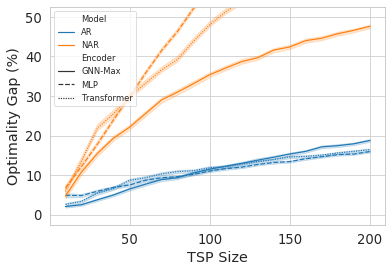

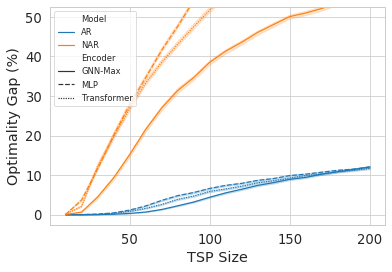

In [19]:
class opts1:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931',
      'outputs/tspsl_20-50/sl-ar-var-full-mlp_20200306T182155',
      'outputs/tspsl_20-50/sl-ar-var-full-gat_20200521T141137',
      'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-max_20200308T173056',
      'outputs/tspsl_20-50/sl-nar-var-full-mlp_20200306T182142',
      'outputs/tspsl_20-50/sl-nar-var-full-gat_20200521T124702',
      # 'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-graphmask_20200320T002725',
      # 'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-max-graphmask_20200320T002834',
    ]
    names = [
      'AR', 'AR', 'AR', 'NAR', 'NAR', 'NAR', # 'AR (graph mask)', 'NAR (graph mask)'
    ]
    addn = ['GNN-Max', 'MLP', 'Transformer', 'GNN-Max', 'MLP', 'Transformer'] # 'GNN-Max', 'GNN-Max']
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'greedy'
    width = 0
    offset = 0
    val_size = 25600
    
class opts2:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931',
      'outputs/tspsl_20-50/sl-ar-var-full-mlp_20200306T182155',
      'outputs/tspsl_20-50/sl-ar-var-full-gat_20200521T141137',
      'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-max_20200308T173056',
      'outputs/tspsl_20-50/sl-nar-var-full-mlp_20200306T182142',
      'outputs/tspsl_20-50/sl-nar-var-full-gat_20200521T124702',
      # 'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-graphmask_20200320T002725',
      # 'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-max-graphmask_20200320T002834',
    ]
    names = [
      'AR', 'AR', 'AR', 'NAR', 'NAR', 'NAR', # 'AR (graph mask)', 'NAR (graph mask)'
    ]
    addn = ['GNN-Max', 'MLP', 'Transformer', 'GNN-Max', 'MLP', 'Transformer'] # 'GNN-Max', 'GNN-Max']
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 128
    offset = 0
    val_size = 25600    

    
ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue="Model", style="Encoder", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts1], addn_col_name="Encoder")
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2.5, 52.5))
# ax.set_title("Decoder architecture (Greedy search)")
ax.get_figure().savefig("results/img/decoder-sl-var-knn-gnn_max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue="Model", style="Encoder", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts2], addn_col_name="Encoder")
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2.5, 52.5))
# ax.set_title("Decoder architecture (Beam search, width=128)")
ax.get_figure().savefig("results/img/decoder-sl-var-knn-gnn_max-bs128.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

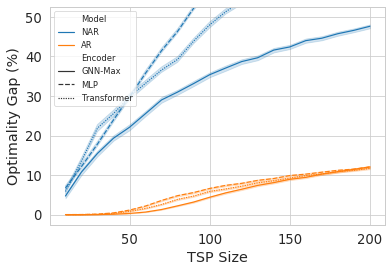

In [20]:
class opts1:
    models = [
      'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-max_20200308T173056',
      'outputs/tspsl_20-50/sl-nar-var-full-mlp_20200306T182142',
      'outputs/tspsl_20-50/sl-nar-var-full-gat_20200521T124702',
    ]
    names = [
      'NAR', 'NAR', 'NAR',
    ]
    addn = ['GNN-Max', 'MLP', 'Transformer']
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'greedy'
    width = 0
    offset = 0
    val_size = 25600
    
class opts2:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931',
      'outputs/tspsl_20-50/sl-ar-var-full-mlp_20200306T182155',
      'outputs/tspsl_20-50/sl-ar-var-full-gat_20200521T141137',
    ]
    names = [
      'AR', 'AR', 'AR'
    ]
    addn = ['GNN-Max', 'MLP', 'Transformer']
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 128
    offset = 0
    val_size = 25600    

    
df_plot = opts_to_df([opts1], addn_col_name="Encoder")
df_plot = df_plot.append(opts_to_df([opts2], addn_col_name="Encoder"))

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue="Model", style="Encoder", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=df_plot
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-2.5, 52.5))
# ax.set_title("Decoder architecture (Greedy search)")
ax.get_figure().savefig("results/img/decoder-sl-var-knn-gnn_max.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

## Findings
- Clearly, for our modest experimental setup, AR decoders are able to learn significantly better solvers for TSP across all scales. We believe NAR architecture is a poor inductive bias for TSP, because it requires significantly more compute to achieve good performance on training size ranges (which we show later) and does not promote generalization to larger sizes at all.
- AR decoders provide a useful inductive bias for TSP as they mimic the step-by-step nature of the problem, i.e., the solution of TSP is an ordered/sequential set. Even without using graph structure, AR decoding learns useful TSP solvers whereas NAR decoding fails completely. 
- However, NAR decoding is significantly faster in terms of evaluation time:

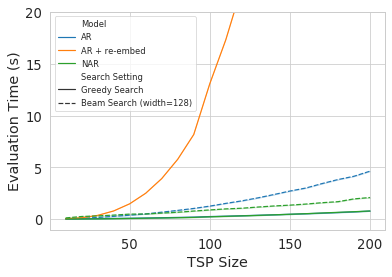

In [5]:
class opts1:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931',
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931-re-embed',
      'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-max_20200308T173056',
    ]
    names = [
      'AR', 
      'AR + re-embed', 
      'NAR',
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'greedy'
    width = 0
    offset = 0
    val_size = 25600
    
class opts2:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931',
      # 'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931-re-embed',
      'outputs/tspsl_20-50/sl-nar-var-20pnn-gnn-max_20200308T173056',
    ]
    names = [
      'AR', 
      # 'AR + re-embed', 
      'NAR',
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 128
    offset = 0
    val_size = 25600    

    
ax = sns.lineplot(x="TSP Size", y="Evaluation Time", 
                  hue="Model", style="Search Setting", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts1, opts2])
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-1, 20))
ax.set(ylabel="Evaluation Time (s)")
# ax.set_title("Evaluation time for decoder architectures")
ax.get_figure().savefig("results/img/decoder_timing-sl-var-knn-gnn_max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

---

# Impact of Learning paradigm

1. **Problem Definition:** TSP20-50 graphs, sparse `20%`-NN graphs
2. **Graph Encoding:** Graph ConvNet with Max Aggregation
3. **Solution Decoding:** Autoregressive
4. **Solution Search:** Greedy search, Beam search
5. **Policy Learning:** Separate models are trained with the following learning paradigms:
    - SL: Standard supervised learning
    - RL-critic: Reinforcement learning with REINFORCE loss, where the baseline is given by a critic model trained alongside the actor model
    - RL-rollout: RL with REINFORCE loss, where we use the greedy rollout baseline proposed by Kool et al., 2019

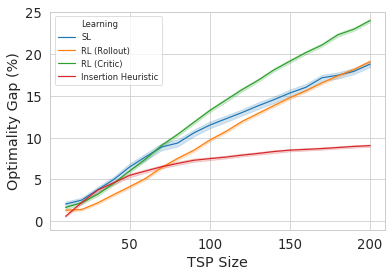

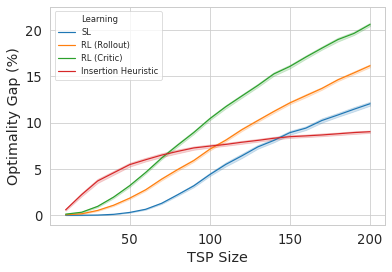

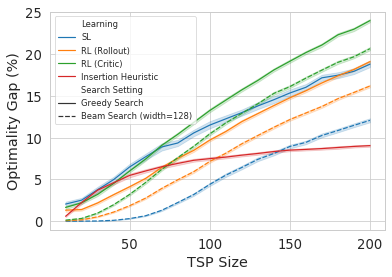

In [4]:
class opts1:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931',
      'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max_20200313T002243',
      'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-critic_20200313T002323'
    ]
    names = [
      'SL', 'RL (Rollout)', 'RL (Critic)'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'greedy'
    width = 0
    offset = 0
    val_size = 25600
    
class opts2:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max_20200308T172931',
      'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max_20200313T002243',
      'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-critic_20200313T002323'
    ]
    names = [
      'SL', 'RL (Rollout)', 'RL (Critic)'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 128
    offset = 0
    val_size = 25600

    
ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue="Learning", # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts1], addn_col_name="Learning", add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-1, 25))
# ax.set_title("Impact of Learning paradigm (Greedy search)")
ax.get_figure().savefig("results/img/learning-ar-var-knn-gnn_max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue="Learning", # style="Model", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts2], addn_col_name="Learning", add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-1, 22.5))
# ax.set_title("Impact of Learning paradigm (Beam search, width=128)")
ax.get_figure().savefig("results/img/learning-ar-var-knn-gnn_max-bs128.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue="Learning", style="Search Setting", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts1, opts2], addn_col_name="Learning", add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-1, 25))
# ax.set_title("Impact of Learning paradigm")
ax.get_figure().savefig("results/img/learning_and_search-ar-var-knn-gnn_max.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

## Findings
- When performing greedy search, it is clear that RL-rollout models generalize better than SL models to larger graphs.
- As we perform Beam search, we see that SL models respond better than RL models. Under Beam search, SL exhibits significantly better zero-shot generalization to larger sizes.
- It is interesting to comment on the relationship between learning paradigm and search. RL-trained models are significantly better under greedy search because, e.g., the greedy rollout baseline encourages the model to constantly improve over its greedy self. Comparatively, SL models are trained with teacher forcing, i.e., immitating the optimal solver at each step. This may explain their poor performance under the greedy setting, but subsequent improvement when doing beam search.

---

# More interactions between Search and Learning paradigm

1. **Problem Definition:** TSP20-50 graphs, sparse `20%`-NN graphs
2. **Graph Encoding:** Graph ConvNet with Max Aggregation and **LayerNorm instead of BatchNorm** (because evaluating with very large beam widths requires using smaller batch sizes, thus motivating the use of batch-independent normalization)
3. **Solution Decoding:** Autoregressive
4. **Solution Search:** Greedy search, Beam search
5. **Policy Learning:** Separate models are trained for SL and RL-rollout

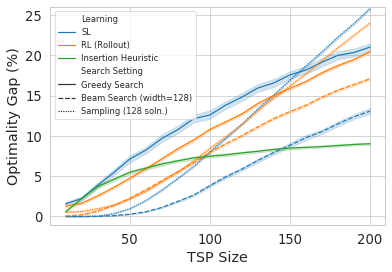

In [5]:
class opts1:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-ln_20200310T095955',
      'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-ln_20200313T125908',
    ]
    names = [
      'SL', 'RL (Rollout)'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'greedy'
    width = 0
    offset = 0
    val_size = 25600
    
class opts2:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-ln_20200310T095955',
      'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-ln_20200313T125908',
    ]
    names = [
      'SL', 'RL (Rollout)'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 128
    offset = 0
    val_size = 25600
    
class opts3:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-ln_20200310T095955',
      'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-ln_20200313T125908',
    ]
    names = [
      'SL', 'RL (Rollout)'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'sample'
    width = 128
    offset = 0
    val_size = 25600
    

ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue="Learning", style="Search Setting", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts1, opts2, opts3], addn_col_name="Learning", add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-1, 26))
# ax.set_title("Interaction between Search and Learning paradigm")
ax.get_figure().savefig("results/img/learning_and_search-ar-var-knn-gnn_max_ln.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

In [6]:
# Compute total inference times

df = opts_to_df([opts1, opts2, opts3], addn_col_name="Learning")

search_to_bs = {"Greedy Search": 16, "Beam Search (width=128)": 16, "Sampling (128 soln.)": 1}

for model in ["SL"]:
    df_temp = df[df["Model"] == model]
    
    for search in ["Greedy Search", "Beam Search (width=128)", "Sampling (128 soln.)"]:
        
        df_temp_search = df_temp[df_temp["Search Setting"] == search]
        
        for size in [20, 50, 100, 200]:
            time = df_temp_search[df_temp_search["TSP Size"] == size]["Evaluation Time"].sum() / search_to_bs[search]
            print(model, search, size, time)

SL Greedy Search 20 2.61785626411438
SL Greedy Search 50 7.451826095581055
SL Greedy Search 100 19.042284965515137
SL Greedy Search 200 54.8819260597229
SL Beam Search (width=128) 20 7.066677093505859
SL Beam Search (width=128) 50 29.089227199554443
SL Beam Search (width=128) 100 98.26140642166138
SL Beam Search (width=128) 200 372.09086775779724
SL Sampling (128 soln.) 20 63.376511573791504
SL Sampling (128 soln.) 50 86.48150444030762
SL Sampling (128 soln.) 100 180.30706548690796
SL Sampling (128 soln.) 200 479.37943148612976


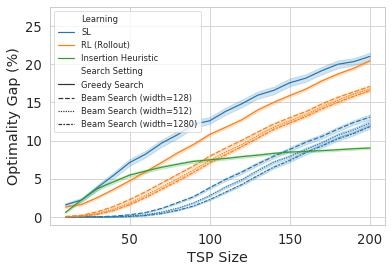

In [79]:
class opts1:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-ln_20200310T095955',
      'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-ln_20200313T125908',
    ]
    names = [
      'SL', 'RL (Rollout)'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'greedy'
    width = 0
    offset = 0
    val_size = 25600
    
class opts2:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-ln_20200310T095955',
      'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-ln_20200313T125908',
    ]
    names = [
      'SL', 'RL (Rollout)'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 128
    offset = 0
    val_size = 25600
    
class opts3:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-ln_20200310T095955',
      'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-ln_20200313T125908',
    ]
    names = [
      'SL', 'RL (Rollout)'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 512
    offset = 0
    val_size = 25600
    
class opts4:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-ln_20200310T095955',
      'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-ln_20200313T125908',
    ]
    names = [
      'SL', 'RL (Rollout)'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'bs'
    width = 1280
    offset = 0
    val_size = 25600
    
    
ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue="Learning", style="Search Setting", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts1, opts2, opts3, opts4], addn_col_name="Learning", add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-1, 27.5))
# ax.set_title("Increasing Beam search width for various Learning paradigms")
ax.get_figure().savefig("results/img/bs_and_learning-ar-var-knn-gnn_max_ln.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

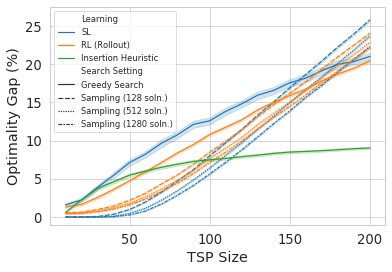

In [80]:
class opts1:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-ln_20200310T095955',
      'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-ln_20200313T125908',
    ]
    names = [
      'SL', 'RL (Rollout)'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'greedy'
    width = 0
    offset = 0
    val_size = 25600
    
class opts2:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-ln_20200310T095955',
      'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-ln_20200313T125908',
    ]
    names = [
      'SL', 'RL (Rollout)'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'sample'
    width = 128
    offset = 0
    val_size = 25600
    
class opts3:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-ln_20200310T095955',
      'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-ln_20200313T125908',
    ]
    names = [
      'SL', 'RL (Rollout)'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'sample'
    width = 512
    offset = 0
    val_size = 25600
    
class opts4:
    models = [
      'outputs/tspsl_20-50/sl-ar-var-20pnn-gnn-max-ln_20200310T095955',
      'outputs/tsp_20-50/rl-ar-var-20pnn-gnn-max-ln_20200313T125908',
    ]
    names = [
      'SL', 'RL (Rollout)'
    ]
    addn = names
    dataset = 'data/tsp/tsp10-200_concorde.txt'
    decode_strategy = 'sample'
    width = 1280
    offset = 0
    val_size = 25600
    
    
ax = sns.lineplot(x="TSP Size", y="Optimality Gap (%)", 
                  hue="Learning", style="Search Setting", # palette=["r", "g", "b"],
                  ci=99, err_style='band',
                  data=opts_to_df([opts1, opts2, opts3, opts4], addn_col_name="Learning", add_heuristic=True)
)
ax.legend(loc=2, fontsize='xx-small')
ax.set(ylim=(-1, 27.5))
# ax.set_title("Sampling more solutions for various Learning paradigms")
ax.get_figure().savefig("results/img/sample_and_learning-ar-var-knn-gnn_max_ln.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

---

# Impact of scaling models and computation

1. **Problem Definition:** TSP20-50 graphs, sparse `20%`-NN graphs
2. **Graph Encoding:** Graph ConvNet with Max Aggregation, separate models are trained at various parameter budgets/scales
3. **Solution Decoding:** Separate models are trained with Autoregressive and Non-autoregressive decoders
4. **Solution Search:** Greedy search, Beam search
5. **Policy Learning:** Separate models are trained for SL and RL-rollout

In this set of experiments, we want to further explore the impact of scaling model parameters and computation times for both AR and NAR decoder architectures. We want to explore the following questions:
1. Using bigger models should lead to better performance on the training size, but does it significantly improve generalization?
    - For AR decoders, we set GNN encoder layers L = 3, 6, and 9.
    - For NAR decoders, we set GNN encoder layers L = 4, 7, and 10.
2. What happens when we continue to train models at various scales indefinitely? Is there are point where learning converges/overfits (in the case of SL)?
    - For SL training, we train for up to 100 epochs instead of the usual 10, i.e., 128,000,000 samples (but only 1,280,000 unique samples).
    - For RL training, we train for 100 epochs (as usual) with 1,280,000 samples per epoch instead of the usual 128,000, i.e., 128,000,000 samples (all unique).


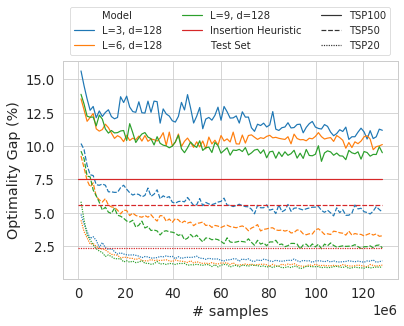

In [9]:
class opts1:
    models = [
        "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max_20200313T004444-tag-val1_opt_gap",
        "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max-6L_20200314T114408-tag-val1_opt_gap",
        "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max-9L_20200313T004811-tag-val1_opt_gap",
#         "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max_20200313T004036-tag-val1_opt_gap",
#         "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-6L_20200319T161822-tag-val1_opt_gap",
#         "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-9L_20200319T161715-tag-val1_opt_gap"
    ]
    names = [
        "L=3, d=128",
        "L=6, d=128",
        "L=9, d=128",
#         "L=3, d=128 (RL)",
#         "L=6, d=128 (RL)",
#         "L=9, d=128 (RL)"
    ]
    batch_sizes = [
        64,
        64,
        16,
#         64,
#         64,
#         16
    ]
    datasets = [
        "TSP20", "TSP20", "TSP20", # "TSP20", "TSP20", "TSP20"
    ]

class opts2:
    models = [
        "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max_20200313T004444-tag-val2_opt_gap",
        "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max-6L_20200314T114408-tag-val2_opt_gap",
        "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max-9L_20200313T004811-tag-val2_opt_gap",
#         "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max_20200313T004036-tag-val2_opt_gap",
#         "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-6L_20200319T161822-tag-val2_opt_gap",
#         "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-9L_20200319T161715-tag-val2_opt_gap"
    ]
    names = [
        "L=3, d=128",
        "L=6, d=128",
        "L=9, d=128",
#         "L=3, d=128 (RL)",
#         "L=6, d=128 (RL)",
#         "L=9, d=128 (RL)"
    ]
    batch_sizes = [
        64,
        64,
        16,
#         64,
#         64,
#         16
    ]
    datasets = [
        "TSP50", "TSP50", "TSP50", # "TSP50", "TSP50", "TSP50"
    ]

class opts3:
    models = [
        "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max_20200313T004444-tag-val3_opt_gap",
        "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max-6L_20200314T114408-tag-val3_opt_gap",
        "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max-9L_20200313T004811-tag-val3_opt_gap",
#         "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max_20200313T004036-tag-val3_opt_gap",
#         "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-6L_20200319T161822-tag-val3_opt_gap",
#         "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-9L_20200319T161715-tag-val3_opt_gap"
    ]
    names = [
        "L=3, d=128",
        "L=6, d=128",
        "L=9, d=128",
#         "L=3, d=128 (RL)",
#         "L=6, d=128 (RL)",
#         "L=9, d=128 (RL)"
    ]
    batch_sizes = [
        64,
        64,
        16,
#         64,
#         64,
#         16
    ]
    datasets = [
        "TSP100", "TSP100", "TSP100", # "TSP100", "TSP100", "TSP100"
    ]
    
    
df_plot = pd.DataFrame(columns=["Time", "# batches", "Optimality Gap (%)", "Model", "Test Set", "# samples"])

for opts in [opts3, opts2, opts1]:
    for model, name, batch_size, dataset in zip(opts.models, opts.names, opts.batch_sizes, opts.datasets):
        df_temp = pd.DataFrame(json.load(open(f"results/tb-logs/{model}.json")), 
                               columns=["Time", "# batches", "Optimality Gap (%)"])
        df_temp["Model"] = [name]*len(df_temp)
        df_temp["Test Set"] = [dataset]*len(df_temp)
        df_temp["# samples"] = df_temp["# batches"] * batch_size
        df_plot = df_plot.append(df_temp)

df_temp = pd.DataFrame.from_dict({
    "Time": [0, 0, 0, 0, 0, 0], 
    "# batches": [0, 128*1e6, 0, 128*1e6, 0, 128*1e6], 
    "Optimality Gap (%)": [2.353, 2.353, 5.601, 5.601, 7.559, 7.559], 
    "Model": ["Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic"], 
    "Test Set": ["TSP20", "TSP20", "TSP50", "TSP50", "TSP100", "TSP100"], 
    "# samples": [0, 128*1e6, 0, 128*1e6, 0, 128*1e6]
})
df_plot = df_plot.append(df_temp)
        
ax = sns.lineplot(x="# samples", y="Optimality Gap (%)", 
                  hue="Model", style="Test Set", # palette=["r", "g", "b"],
                  data=df_plot
)
ax.legend(loc=9, ncol=3, bbox_to_anchor=(0.5, 1.25), borderaxespad=0., fontsize='x-small')
# ax.legend(loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize='x-small')
plt.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
# ax.set_title("Impact of scaling model and computation (AR decoder)")
ax.get_figure().savefig("results/img/scale-ar-sl-var-knn-gnn_max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

## Note

The above plot is different from the usual plot: here, we plot Optimality Gap (y-axis) vs. number of training samples (x-axis) for models at various parameter budgets but trained on the same training data of instances TSP20-50. The optimality gaps are measures for 3 separate held out test sets of 1280 instance each of TSP20, TSP50 and TSP100:
- TSP20 performance shows how the model performs on held out samples of the same size as the **smallest training instance**
- TSP50 performance shows how the model performs on held out samples of the same size as the **largest training instance**
- TSP100 performance shows the model's ability to generalize to sizes **larger than those seen in training**

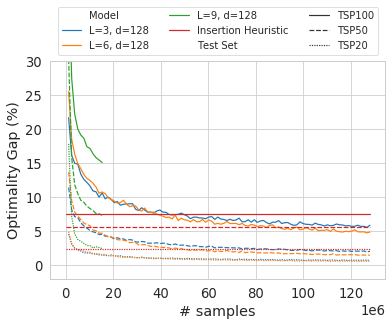

In [5]:
class opts1:
    models = [
        "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max_20200313T004036-tag-val1_opt_gap",
        "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-6L_20200319T161822-tag-val1_opt_gap",
        "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-9L-lowlr_20200513T135614-tag-val1_opt_gap"
    ]
    names = [
        "L=3, d=128",
        "L=6, d=128",
        "L=9, d=128",
    ]
    batch_sizes = [
        64,
        64,
        16
    ]
    datasets = [
        "TSP20", "TSP20", "TSP20"
    ]

class opts2:
    models = [
        "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max_20200313T004036-tag-val2_opt_gap",
        "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-6L_20200319T161822-tag-val2_opt_gap",
        "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-9L-lowlr_20200513T135614-tag-val2_opt_gap"
    ]
    names = [
        "L=3, d=128",
        "L=6, d=128",
        "L=9, d=128",
    ]
    batch_sizes = [
        64,
        64,
        16,
    ]
    datasets = [
        "TSP50", "TSP50", "TSP50"
    ]

class opts3:
    models = [
        "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max_20200313T004036-tag-val3_opt_gap",
        "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-6L_20200319T161822-tag-val3_opt_gap",
        "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-9L-lowlr_20200513T135614-tag-val3_opt_gap"
    ]
    names = [
        "L=3, d=128",
        "L=6, d=128",
        "L=9, d=128",
    ]
    batch_sizes = [
        64,
        64,
        16,
    ]
    datasets = [
        "TSP100", "TSP100", "TSP100"
    ]
    
    
df_plot = pd.DataFrame(columns=["Time", "# batches", "Optimality Gap (%)", "Model", "Test Set", "# samples"])

for opts in [opts3, opts2, opts1]:
    for model, name, batch_size, dataset in zip(opts.models, opts.names, opts.batch_sizes, opts.datasets):
        df_temp = pd.DataFrame(json.load(open(f"results/tb-logs/{model}.json")), 
                               columns=["Time", "# batches", "Optimality Gap (%)"])
        df_temp["Model"] = [name]*len(df_temp)
        df_temp["Test Set"] = [dataset]*len(df_temp)
        df_temp["# samples"] = df_temp["# batches"] * batch_size
        df_plot = df_plot.append(df_temp)

df_temp = pd.DataFrame.from_dict({
    "Time": [0, 0, 0, 0, 0, 0], 
    "# batches": [0, 128*1e6, 0, 128*1e6, 0, 128*1e6], 
    "Optimality Gap (%)": [2.353, 2.353, 5.601, 5.601, 7.559, 7.559], 
    "Model": ["Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic"], 
    "Test Set": ["TSP20", "TSP20", "TSP50", "TSP50", "TSP100", "TSP100"], 
    "# samples": [0, 128*1e6, 0, 128*1e6, 0, 128*1e6]
})
df_plot = df_plot.append(df_temp)
        
ax = sns.lineplot(x="# samples", y="Optimality Gap (%)", 
                  hue="Model", style="Test Set", # palette=["r", "g", "b"],
                  data=df_plot
)
# ax.legend(loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize='x-small')
ax.legend(loc=9, ncol=3, bbox_to_anchor=(0.5, 1.25), borderaxespad=0., fontsize='x-small')
ax.set(ylim=(-2, 30))
plt.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
# ax.set_title("Impact of scaling model and computation (AR decoder)")
ax.get_figure().savefig("results/img/scale-ar-rl-var-knn-gnn_max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

/home/chaitanya/miniconda3/envs/tsp/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


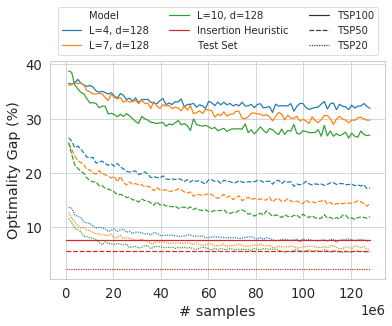

In [6]:
class opts1:
    models = [
        "run-tspsl_20-50_scale-sl-nar-var-0.2nn-gnn-max_20200313T005057-tag-val1_opt_gap",
        "run-tspsl_20-50_scale-sl-nar-var-0.2nn-gnn-max-7L_20200314T114546-tag-val1_opt_gap",
        "run-tspsl_20-50_scale-sl-nar-var-0.2nn-gnn-max-10L_20200313T005139-tag-val1_opt_gap",
    ]
    names = [
        "L=4, d=128",
        "L=7, d=128",
        "L=10, d=128"
    ]
    batch_sizes = [
        64,
        64,
        16
    ]
    datasets = [
        "TSP20", "TSP20", "TSP20"
    ]

class opts2:
    models = [
        "run-tspsl_20-50_scale-sl-nar-var-0.2nn-gnn-max_20200313T005057-tag-val2_opt_gap",
        "run-tspsl_20-50_scale-sl-nar-var-0.2nn-gnn-max-7L_20200314T114546-tag-val2_opt_gap",
        "run-tspsl_20-50_scale-sl-nar-var-0.2nn-gnn-max-10L_20200313T005139-tag-val2_opt_gap",
    ]
    names = [
        "L=4, d=128",
        "L=7, d=128",
        "L=10, d=128"
    ]
    batch_sizes = [
        64,
        64,
        16
    ]
    datasets = [
        "TSP50", "TSP50", "TSP50"
    ]

class opts3:
    models = [
        "run-tspsl_20-50_scale-sl-nar-var-0.2nn-gnn-max_20200313T005057-tag-val3_opt_gap",
        "run-tspsl_20-50_scale-sl-nar-var-0.2nn-gnn-max-7L_20200314T114546-tag-val3_opt_gap",
        "run-tspsl_20-50_scale-sl-nar-var-0.2nn-gnn-max-10L_20200313T005139-tag-val3_opt_gap",
    ]
    names = [
        "L=4, d=128",
        "L=7, d=128",
        "L=10, d=128"
    ]
    batch_sizes = [
        64,
        64,
        16
    ]
    datasets = [
        "TSP100", "TSP100", "TSP100"
    ]
    
    
df_plot = pd.DataFrame(columns=["Time", "# batches", "Optimality Gap (%)", "Model", "Dataset", "# samples"])

for opts in [opts3, opts2, opts1]:
    for model, name, batch_size, dataset in zip(opts.models, opts.names, opts.batch_sizes, opts.datasets):
        df_temp = pd.DataFrame(json.load(open(f"results/tb-logs/{model}.json")), 
                               columns=["Time", "# batches", "Optimality Gap (%)"])
        df_temp["Model"] = [name]*len(df_temp)
        df_temp["Test Set"] = [dataset]*len(df_temp)
        df_temp["# samples"] = df_temp["# batches"] * batch_size
        df_plot = df_plot.append(df_temp)

df_temp = pd.DataFrame.from_dict({
    "Time": [0, 0, 0, 0, 0, 0], 
    "# batches": [0, 128*1e6, 0, 128*1e6, 0, 128*1e6], 
    "Optimality Gap (%)": [2.353, 2.353, 5.601, 5.601, 7.559, 7.559], 
    "Model": ["Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic"], 
    "Test Set": ["TSP20", "TSP20", "TSP50", "TSP50", "TSP100", "TSP100"], 
    "# samples": [0, 128*1e6, 0, 128*1e6, 0, 128*1e6]
})
df_plot = df_plot.append(df_temp)

ax = sns.lineplot(x="# samples", y="Optimality Gap (%)", 
                  hue="Model", style="Test Set", # palette=["r", "g", "b"],
                  data=df_plot
)
# ax.legend(loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize='x-small')
ax.legend(loc=9, ncol=3, bbox_to_anchor=(0.5, 1.25), borderaxespad=0., fontsize='x-small')
plt.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
# ax.set_title("Impact of scaling model and computation (NAR decoder)")
ax.get_figure().savefig("results/img/scale-nar-sl-var-knn-gnn_max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

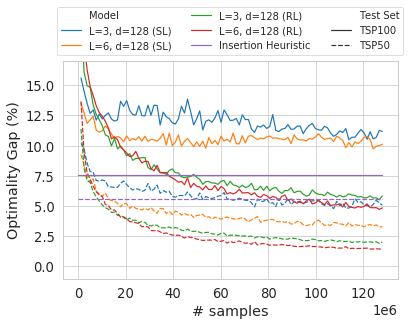

In [7]:
class opts1:
    models = [
        "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max_20200313T004444-tag-val1_opt_gap",
        "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max-6L_20200314T114408-tag-val1_opt_gap",
#         "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max-9L_20200313T004811-tag-val1_opt_gap",
        "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max_20200313T004036-tag-val1_opt_gap",
        "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-6L_20200319T161822-tag-val1_opt_gap",
#         "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-9L_20200319T161715-tag-val1_opt_gap"
    ]
    names = [
        "L=3, d=128 (SL)",
        "L=6, d=128 (SL)",
#         "L=9, d=128",
        "L=3, d=128 (RL)",
        "L=6, d=128 (RL)",
#         "L=9, d=128 (RL)"
    ]
    batch_sizes = [
        64,
        64,
#         16,
        64,
        64,
#         16
    ]
    datasets = [
        "TSP20", "TSP20", "TSP20", "TSP20", # "TSP20", # "TSP20"
    ]

class opts2:
    models = [
        "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max_20200313T004444-tag-val2_opt_gap",
        "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max-6L_20200314T114408-tag-val2_opt_gap",
#         "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max-9L_20200313T004811-tag-val2_opt_gap",
        "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max_20200313T004036-tag-val2_opt_gap",
        "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-6L_20200319T161822-tag-val2_opt_gap",
#         "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-9L_20200319T161715-tag-val2_opt_gap"
    ]
    names = [
        "L=3, d=128 (SL)",
        "L=6, d=128 (SL)",
#         "L=9, d=128",
        "L=3, d=128 (RL)",
        "L=6, d=128 (RL)",
#         "L=9, d=128 (RL)"
    ]
    batch_sizes = [
        64,
        64,
#         16,
        64,
        64,
#         16
    ]
    datasets = [
        "TSP50", "TSP50", "TSP50", "TSP50", # "TSP50", # "TSP50"
    ]

class opts3:
    models = [
        "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max_20200313T004444-tag-val3_opt_gap",
        "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max-6L_20200314T114408-tag-val3_opt_gap",
#         "run-tspsl_20-50_scale-sl-ar-var-0.2nn-gnn-max-9L_20200313T004811-tag-val3_opt_gap",
        "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max_20200313T004036-tag-val3_opt_gap",
        "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-6L_20200319T161822-tag-val3_opt_gap",
#         "run-tsp_20-50_scale-rl-ar-var-0.2nn-gnn-max-9L_20200319T161715-tag-val3_opt_gap"
    ]
    names = [
        "L=3, d=128 (SL)",
        "L=6, d=128 (SL)",
#         "L=9, d=128",
        "L=3, d=128 (RL)",
        "L=6, d=128 (RL)",
#         "L=9, d=128 (RL)"
    ]
    batch_sizes = [
        64,
        64,
#         16,
        64,
        64,
#         16
    ]
    datasets = [
        "TSP100", "TSP100", "TSP100", "TSP100", # "TSP100", # "TSP100"
    ]
    
    
df_plot = pd.DataFrame(columns=["Time", "# batches", "Optimality Gap (%)", "Model", "Test Set", "# samples"])

for opts in [opts3, opts2]:
    for model, name, batch_size, dataset in zip(opts.models, opts.names, opts.batch_sizes, opts.datasets):
        df_temp = pd.DataFrame(json.load(open(f"results/tb-logs/{model}.json")), 
                               columns=["Time", "# batches", "Optimality Gap (%)"])
        df_temp["Model"] = [name]*len(df_temp)
        df_temp["Test Set"] = [dataset]*len(df_temp)
        df_temp["# samples"] = df_temp["# batches"] * batch_size
        df_plot = df_plot.append(df_temp)

# df_temp = pd.DataFrame.from_dict({
#     "Time": [0, 0, 0, 0, 0, 0], 
#     "# batches": [0, 128*1e6, 0, 128*1e6, 0, 128*1e6], 
#     "Optimality Gap (%)": [2.353, 2.353, 5.601, 5.601, 7.559, 7.559], 
#     "Model": ["Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic"], 
#     "Test Set": ["TSP20", "TSP20", "TSP50", "TSP50", "TSP100", "TSP100"], 
#     "# samples": [0, 128*1e6, 0, 128*1e6, 0, 128*1e6]
# })
df_temp = pd.DataFrame.from_dict({
    "Time": [0, 0, 0, 0], 
    "# batches": [0, 128*1e6, 0, 128*1e6], 
    "Optimality Gap (%)": [5.601, 5.601, 7.559, 7.559], 
    "Model": ["Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic", "Insertion Heuristic"], 
    "Test Set": ["TSP50", "TSP50", "TSP100", "TSP100"], 
    "# samples": [0, 128*1e6, 0, 128*1e6]
})
df_plot = df_plot.append(df_temp)
        
# ax = sns.lineplot(x="# samples", y="Optimality Gap (%)", 
#                   hue="Model", style="Test Set", # palette=["r", "g", "b"],
#                   data=df_plot
# )
# ax.legend(loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize='x-small')
# plt.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
# ax.set(ylim=(-1, 17))
# # ax.set_title("Impact of scaling model and computation (AR decoder)")
# ax.get_figure().savefig("results/img/scale-ar-var-knn-gnn_max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
# plt.show()

ax = sns.lineplot(x="# samples", y="Optimality Gap (%)", 
                  hue="Model", style="Test Set", # palette=["r", "g", "b"],
                  data=df_plot
)
ax.legend(loc=9, ncol=3, bbox_to_anchor=(0.5, 1.25), borderaxespad=0., fontsize='x-small')
plt.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
ax.set(ylim=(-1, 17))
# ax.set_title("Impact of scaling model and computation (AR decoder)")
ax.get_figure().savefig("results/img/scale-ar-var-knn-gnn_max-greedy-legend-on-top.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

---

# Impact of scaling datasets (TODO)

1. **Problem Definition:** Separate models are trained for TSP20-50 graphs and **TSP50-100 graphs** (sparse `20%`-NN graphs) in order to measure the impact of using **more** as well as **larger** training samples  
2. **Graph Encoding:** Graph ConvNet with Max Aggregation, separate models are trained at various parameter budgets/scales
3. **Solution Decoding:** Separate models are trained with Autoregressive and Non-autoregressive decoders
4. **Solution Search:** Greedy search, Beam search
5. **Policy Learning:** RL-rollout **(because we cannot generate supervised training sets for larger graphs)**

In this set of experiments, we want to explore an orthogonal trajectory to our original aim:
1. What is the impact of using larger and more complex problem instances for training?
    - Doing a lot of experiments on large graphs is impossible for our lab. But if I were at Google/a company, I would throw more compute at the problem. Let us attempt to do that and let the experiments run for several days!
2. Are the training sizes we used in our experiments way too small to learn useful solutions for TSP? Maybe training on larger and more complex graphs is the way to go if one wants to learn useful solvers for generalization to even larger scales?

---

# Finetuning and Active Search

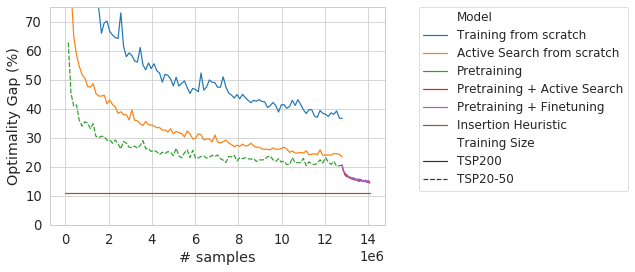

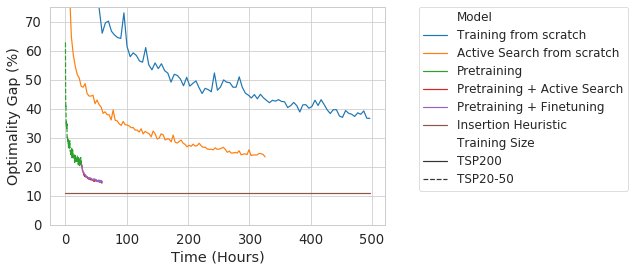

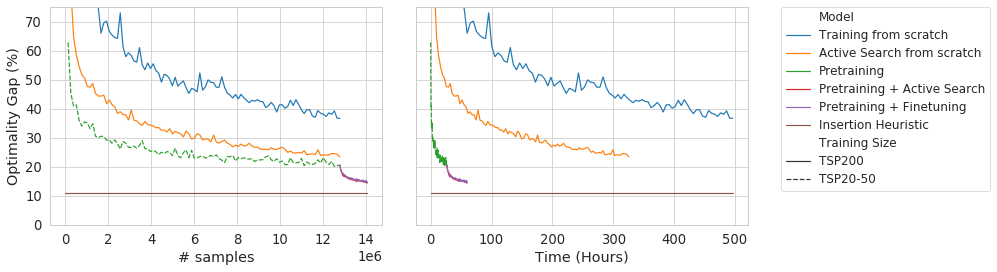

In [69]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

class opts1:
    models = [
        "run-tsp_200-200_rl-ar-200-20pnn-gnn-max-ln-lowlr_20200428T092228-tag-val1_opt_gap",
        "run-tsp_200-200_rl-ar-200-20pnn-gnn-max-ln-lowlr_20200428T092228_active-exp-lr1e-5-from-scratch_20200510T162714-tag-val_ft_opt_gap",
#         "run-tsp_10-200_rl-ar-var-0.2nn-gnn-max-ln-curriculum-10-200_20200513T141622-tag-val1_opt_gap",
#         "run-tsp_10-200_rl-ar-var-0.2nn-gnn-max-ln-curriculum-10-200-lowlr_20200518T133522-tag-val1_opt_gap",
        "run-tsp_20-50_rl-ar-var-20pnn-gnn-max-ln-rerun_20200427T123442-tag-val1_opt_gap",
    ]
    names = [
        "Training from scratch",
        "Active Search from scratch",
#         "Curriculum Learning-1",
#         "Curriculum Learning-2",
        "Pretraining",
    ]
    batch_sizes = [
        16, 16, 128,
    ]
    datasets = [
        "TSP200", "TSP200", "TSP20-50" # "TSP10-200 (curriculum)", "TSP10-200 (curriculum)", "TSP20-50",
    ]
    
class opts2:
    models = [
        "run-tsp_20-50_rl-ar-var-20pnn-gnn-max-ln-rerun_20200427T123442_active-exp-lr1e-5_20200504T132432-tag-val_ft_opt_gap",
        "run-tsp_20-50_rl-ar-var-20pnn-gnn-max-ln-rerun_20200427T123442_random-exp-lr1e-5_20200504T132628-tag-val_ft_opt_gap",
    ]
    names = [
        "Pretraining + Active Search",
        "Pretraining + Finetuning",
    ]
    batch_sizes = [
        16, 16,
    ]
    datasets = [
        "TSP200", "TSP200",
    ]
    
    
df_plot = pd.DataFrame(columns=["Time", "# batches", "Optimality Gap (%)", "Model", "Training Size", "# samples"])

# From scratch training
for opts in [opts1]:
    for model, name, batch_size, dataset in zip(opts.models, opts.names, opts.batch_sizes, opts.datasets):
        df_temp = pd.DataFrame(json.load(open(f"results/tb-logs/{model}.json")), 
                               columns=["Time", "# batches", "Optimality Gap (%)"])
        df_temp["Model"] = [name]*len(df_temp)
        df_temp["Training Size"] = [dataset]*len(df_temp)
        df_temp["# samples"] = df_temp["# batches"] * batch_size
        df_temp["Time"] = df_temp["Time"] - df_temp["Time"].min()
        
        if name == "Pretraining":
            pretrain_end_time = df_temp["Time"].max()
            
        if name == "Curriculum Learning-1":
            # Fix for Curriculum-1, which terminated at 60 epochs
            df_temp = df_temp[df_temp["# samples"] < 61*128000]
            curriculum_1_end_time = df_temp["Time"].max()
            df_temp["Model"] = ["Curriculum Learning"]*len(df_temp)
        
        if name == "Curriculum Learning-2":
            # Fix for Curriculum-2, which restarted from 60 epochs
            df_temp["Time"] = curriculum_1_end_time + df_temp["Time"]
            df_temp["Model"] = ["Curriculum Learning"]*len(df_temp)
        
        df_plot = df_plot.append(df_temp)
        
# Finetuning after training
for opts in [opts2]:
    for model, name, batch_size, dataset in zip(opts.models, opts.names, opts.batch_sizes, opts.datasets):
        df_temp = pd.DataFrame(json.load(open(f"results/tb-logs/{model}.json")), 
                               columns=["Time", "# batches", "Optimality Gap (%)"])
        df_temp["Model"] = [name]*len(df_temp)
        df_temp["Training Size"] = [dataset]*len(df_temp)
        df_temp["# samples"] = (df_temp["# batches"] * batch_size) + 12.8*1e6
        df_temp["Time"] = df_temp["Time"] - df_temp["Time"].min()
        # Add pre-training time to finetuned models
        df_temp["Time"] = pretrain_end_time + df_temp["Time"]
        df_plot = df_plot.append(df_temp)

df_temp = pd.DataFrame.from_dict({
    "Time": [0, df_plot["Time"].max()], 
    "# batches": [0, (12.8 + 1.28)*1e6], 
    "Optimality Gap (%)": [10.963, 10.963], 
    "Model": ["Insertion Heuristic", "Insertion Heuristic"], 
    "Training Size": ["TSP200", "TSP200"], 
    "# samples": [0, (12.8 + 1.28)*1e6]
})
df_plot = df_plot.append(df_temp)

df_plot["Time"] = df_plot["Time"] / (3600)
df_plot["Time (Hours)"] = df_plot["Time"]


ax = sns.lineplot(x="# samples", y="Optimality Gap (%)", 
                  hue="Model", style="Training Size", # palette=["r", "g", "b"],
                  data=df_plot
)
ax.legend(loc=2, bbox_to_anchor=(1.1, 1), borderaxespad=0., fontsize='small')
plt.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
ax.set(ylim=(0, 75))
# ax.set_title("")
ax.get_figure().savefig("results/img/finetune-tsp200-ar-rl-knn-gnn-max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()



ax = sns.lineplot(x="Time (Hours)", y="Optimality Gap (%)", 
                  hue="Model", style="Training Size", # palette=["r", "g", "b"],
                  data=df_plot,
)
ax.legend(loc=2, bbox_to_anchor=(1.1, 1), borderaxespad=0., fontsize='small')
ax.set(ylim=(0, 75))
# ax.set_title("")
ax.get_figure().savefig("results/img/finetune-time-tsp200-ar-rl-knn-gnn-max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()



fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12.5,4))

sns.lineplot(x="# samples", y="Optimality Gap (%)", 
             hue="Model", style="Training Size", # palette=["r", "g", "b"],
             data=df_plot,
             ax=ax1,
             legend=False,
)
ax1.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
ax1.set(ylim=(0, 75))

sns.lineplot(x="Time (Hours)", y="Optimality Gap (%)", 
             hue="Model", style="Training Size",
             data=df_plot,
             ax=ax2
)
ax2.legend(loc=2, bbox_to_anchor=(1.1, 1), borderaxespad=0., fontsize='small')
ax2.ticklabel_format(style='plain', axis='x')
ax2.set(ylim=(0, 75))

plt.subplots_adjust(wspace=0.1)

fig.savefig("results/img/finetune-subfigs-tsp200-ar-rl-knn-gnn-max-greedy.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

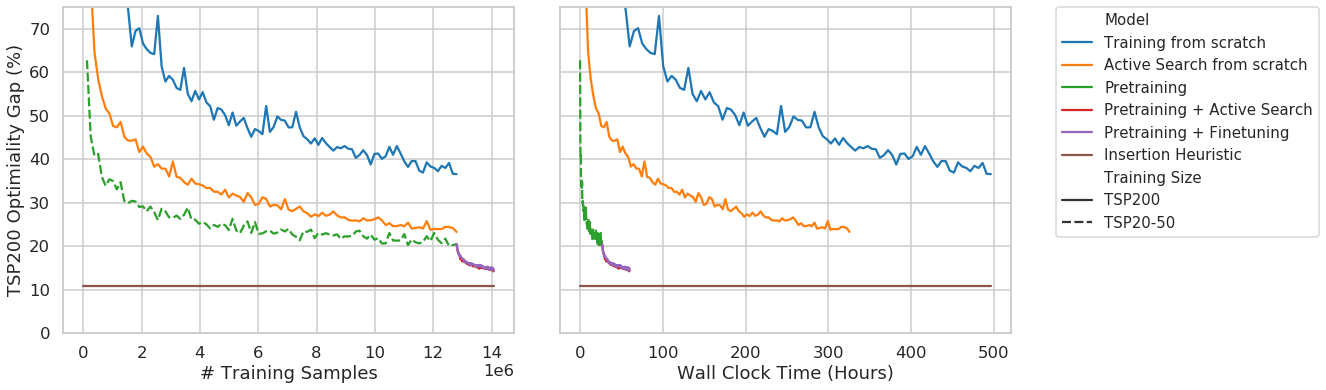

In [73]:
sns.set_context("talk")

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(17,6))

sns.lineplot(x="# samples", y="Optimality Gap (%)", 
             hue="Model", style="Training Size", # palette=["r", "g", "b"],
             data=df_plot,
             ax=ax1,
             legend=False,
)
ax1.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
ax1.set(ylim=(0, 75), ylabel="TSP200 Optimiality Gap (%)", xlabel="# Training Samples")

sns.lineplot(x="Time (Hours)", y="Optimality Gap (%)", 
             hue="Model", style="Training Size",
             data=df_plot,
             ax=ax2
)
ax2.legend(loc=2, bbox_to_anchor=(1.1, 1), borderaxespad=0., fontsize='small')
ax2.ticklabel_format(style='plain', axis='x')
ax2.set(ylim=(0, 75), xlabel="Wall Clock Time (Hours)")

plt.subplots_adjust(wspace=0.1)

fig.savefig("results/img/finetune-subfigs-tsp200-ar-rl-knn-gnn-max-greedy-talk-style.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()